In [1]:
import os
from copy import deepcopy
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

from doctr.utils.visualization import draw_boxes
from pdf2image import convert_from_path

import unstructured_pytesseract

from unstructured.partition.utils.ocr_models.ecoit_ocr import OCRAgentECOIT
from unstructured.partition.utils.ocr_models.ocr_interface import OCRAgent
from unstructured.partition.utils.config import env_config
from unstructured.partition.utils.constants import OCR_AGENT_PADDLE, OCR_AGENT_TESSERACT, OCR_AGENT_ECOIT, OCRMode



/work/hpc/miniconda3/envs/layout/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work/hpc/miniconda3/envs/layout/lib/python3.10/site-packages/gdown/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
%cd /data/hpc/potato/ecoit_summer

/data/hpc/potato/ecoit_summer


In [3]:
%cd /data/hpc/potato/ecoit_summer/
%env OCR_AGENT=unstructured.partition.utils.ocr_models.ecoit_ocr.OCRAgentECOIT
%env DOCTR_MODEL_NAME=linknet_resnet34
%env DOCTR_THRESHOLD=0.0
%env DOCTR_DEVICE=cuda:0
%env DOCTR_DET_CLUSTER=True

%env VIETOCR_MODEL_NAME=vgg_transformer
%env VIETOCR_DEVICE=cuda:0
%env VIETOCR_BATCH_SIZE=64
%env VIETOCR_MAX_TEXT_WIDTH_RATIO=0.5
%env VIETOCR_USE_BEAM_SEARCH=True

/data/hpc/potato/ecoit_summer
env: OCR_AGENT=unstructured.partition.utils.ocr_models.ecoit_ocr.OCRAgentECOIT
env: DOCTR_MODEL_NAME=linknet_resnet34
env: DOCTR_THRESHOLD=0.0
env: DOCTR_DEVICE=cuda:0
env: DOCTR_DET_CLUSTER=True
env: VIETOCR_MODEL_NAME=vgg_transformer
env: VIETOCR_DEVICE=cuda:0
env: VIETOCR_BATCH_SIZE=64
env: VIETOCR_MAX_TEXT_WIDTH_RATIO=0.5
env: VIETOCR_USE_BEAM_SEARCH=True


In [4]:
%cd /data/hpc/potato/ecoit_summer

/data/hpc/potato/ecoit_summer


In [5]:
# images = convert_from_path("data/database/07_KT/2024.TTr phê duyệt TCKT Flycam.pdf", thread_count=8, fmt='png', dpi=400, first_page=1)
# for i, image in enumerate(images): 
#     image.save(f"logs/doc/Flycam/{i:03d}.png")

In [6]:
model = OCRAgentECOIT()

/work/hpc/miniconda3/envs/layout/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model weight /work/hpc/tmp/vgg_transformer.pth exsits. Ignore download!


In [7]:
# pages = convert_from_path(
#                             r"./data/database/Báo cáo/Tieu chuan RMU 2017 5137.pdf",
#                             dpi=400,
#                             use_pdftocairo=True,
# )

In [8]:
# for i, page in enumerate(pages): 
#     page.save(f"./logs/document_{i:03d}.png")

In [9]:
index = 0
image = Image.open(f"./logs/doc/Flycam/{index:03d}.png")

In [10]:
ocr_regions = model.get_layout_from_image(image)

In [11]:
ocr_regions.texts

array(['TỔNG CÔNG TY', 'CỘNG HOÀ XÃ', 'HỘI CHỦ NGHĨA', 'VIỆT NAM',
       'ĐIỆN LỰC TP HÀ', 'NỘI', 'Độc lập - Tự do - Hạnh', 'phúc',
       'BAN KỸ THUẬT', 'Số: 07/KT', 'Hà Nội, ngày 07 tháng',
       '01 năm 2025', 'TỜ TRÌNH', 'Về việc phê duyệt',
       'tiêu chuẩn kỹ thuật', 'thiết bị bay không', 'người lái (UAV)',
       'Kính gửi: Ông Phó', 'Tổng Giám đốc', 'Kỹ thuật',
       'Căn cứ vào Quyết', 'Định số 8594/QĐ-EVNHANOI', 'ngày 06/12/2023',
       'Tổng', 'Công ty Điện lực', 'TP Hà Nội về việc',
       'giao danh muc mua', 'săm tài sản năm', '2024 đợt',
       '2 cho Công ty Lưới', 'điện Cao thế thành', 'phố hà nội;',
       'Ban Kỹ thuật kính', 'trình Tổng Giám', 'đốc phê duyệt tiêu',
       'chuẩn kỹ thuật thiết', 'bị', 'bay không người',
       'lái công nghiệp (UAV)', 'để tổ chức thực', 'hiện mua sắm bổ',
       'sung trang', 'bị cho Công ty Lưới', 'điện cao thế TP',
       'Hà Nội với các nội', 'dung sau:', '1 Các yêu cầu',
       'chung về nhà sản', 'xuất', '- Nhà sản xuất 

In [12]:
text_output = "\n\n".join(ocr_regions.texts)

In [13]:
from typing import List, Optional, Tuple
RGB = Tuple[int, int, int]
def _auto_color(label: Optional[str]) -> RGB:
    if not label:
        return (0, 255, 0)
    h = abs(hash(label))
    return (50 + (h      ) % 206,
            50 + (h // 7) % 206,
            50 + (h // 13) % 206)

def _text_color_for(bg: RGB) -> RGB:
    return (0, 0, 0) 

def draw_bboxes_pil(
    image: Image.Image,
    boxes: List[Tuple[int, int, int, int]],   # [(x1,y1,x2,y2), ...] in pixels
    labels: Optional[List[Optional[str]]] = None,
    colors: Optional[List[Optional[RGB]]] = None,
    thickness: int = 6,
    font: Optional[ImageFont.FreeTypeFont] = None,
    alpha: float = 0.25,                      # label background opacity
    pad: int = 3,                             # label text padding
) -> Image.Image:
    """
    Draw axis-aligned boxes + labels on a PIL image. Returns a new image.
    For full Vietnamese support, pass a TTF/OTF font that includes Vietnamese glyphs
    (e.g., Noto Sans, DejaVu Sans, Roboto).
    """
    if labels is None:
        labels = [None] * len(boxes)
    if colors is None:
        colors = [None] * len(boxes)
    assert len(labels) == len(boxes) and len(colors) == len(boxes)
    font = font if font else ImageFont.truetype("./data/checkpoints/fonts/TIMES.TTF")
    base_mode = image.mode
    base = image.convert("RGBA")
    draw = ImageDraw.Draw(base)
    overlay = Image.new("RGBA", base.size, (0, 0, 0, 0))
    ovr = ImageDraw.Draw(overlay)

    if font is None:
        # Fallback: PIL default (ASCII). For Vietnamese, pass a TrueType font explicitly.
        font = ImageFont.load_default()

    for (x1, y1, x2, y2), label, color in zip(boxes, labels, colors):
        c = color or _auto_color(label)
        # Box outline
        draw.rectangle([x1, y1, x2, y2], outline=(*c, 255), width=max(1, thickness))

        if label:
            # Measure text
            # textbbox returns (l, t, r, b)
            l, t, r, b = draw.textbbox((0, 0), label, font=font)
            tw, th = r - l, b - t

            # Prefer above the box; if not enough room, put inside/under
            y_top = y1 - th - 2 * pad
            y_bot = y1
            if y_top < 0:
                y_top = y1
                y_bot = y1 + th + 2 * pad

            x_left = x1
            x_right = x1 + tw + 2 * pad

            # Translucent background on overlay
            ovr.rectangle(
                [x_left, y_top, x_right, y_bot],
                fill=(c[0], c[1], c[2], int(255 * max(0.0, min(1.0, alpha)))),
            )

            # Text (on base)
            tc = _text_color_for(c)
            print(label)
            draw.text(
                (x_left + pad, y_top + pad),
                label,
                font=font,
                fill=(*tc, 255),
            )

    # Composite overlay and return to original mode
    out = Image.alpha_composite(base, overlay).convert(base_mode)
    return out

In [14]:
np_image = draw_bboxes_pil(image, ocr_regions.element_coords, labels=ocr_regions.texts)

TỔNG CÔNG TY
CỘNG HOÀ XÃ
HỘI CHỦ NGHĨA
VIỆT NAM
ĐIỆN LỰC TP HÀ
NỘI
Độc lập - Tự do - Hạnh
phúc
BAN KỸ THUẬT
Số: 07/KT
Hà Nội, ngày 07 tháng
01 năm 2025
TỜ TRÌNH
Về việc phê duyệt
tiêu chuẩn kỹ thuật
thiết bị bay không
người lái (UAV)
Kính gửi: Ông Phó
Tổng Giám đốc
Kỹ thuật
Căn cứ vào Quyết
Định số 8594/QĐ-EVNHANOI
ngày 06/12/2023
Tổng
Công ty Điện lực
TP Hà Nội về việc
giao danh muc mua
săm tài sản năm
2024 đợt
2 cho Công ty Lưới
điện Cao thế thành
phố hà nội;
Ban Kỹ thuật kính
trình Tổng Giám
đốc phê duyệt tiêu
chuẩn kỹ thuật thiết
bị
bay không người
lái công nghiệp (UAV)
để tổ chức thực
hiện mua sắm bổ
sung trang
bị cho Công ty Lưới
điện cao thế TP
Hà Nội với các nội
dung sau:
1 Các yêu cầu
chung về nhà sản
xuất
- Nhà sản xuất phải có
chứng nhận quản
lý chất lượng ISO
hoặc tương đương.
- Nhà thầu phải
cung cấp đầy đủ
thông tin của sản
phẩm trong phần
thuyết
minh đáp ứng yêu
cầu kỹ thuật và
bảng phụ lục đặc
tính kỹ thuật cam
kết (của tập
tiêu chuẩn kỹ thuật
này), đồng thời
phải cung 

In [15]:
# quads = []
# lines = []
# # To BGR format
# np_image = image.copy()
# print(np_image.size)
# # figure = np_image.cpy()
# low_poly = []
# low_char = []
# xy_shape = list(np_image.size)
# xy_shape.extend(xy_shape)
# for block in page.blocks:
#     for line in block.lines:
#         content = ""
#         for word in line.words:
#             label = f"{word.confidence:.2f}: " + word.value
#             content += " " + word.value
#             # word.geometry is a 4-point quadrilateral ((x,y) in [0,1])
#             if word.confidence < 0.7:
#                 low_char.append(label)
#                 low_poly.append(np.array(word.geometry).flatten())
#             quads.append((np.array(word.geometry).flatten() * xy_shape).astype(int))
#             np_image = draw_bboxes_pil(np_image, [quads[-1].copy().tolist()], labels = [label])
#         lines.append(content)
# quads = np.stack(quads, axis=0)
# low_poly = np.stack(low_poly, axis=0)
# print(lines)
# plt.imshow(np_image)
# plt.axis("off")
# plt.show()

In [16]:
# patches = model.crop_patches(np.asarray(image), low_poly, issorted=False, padding=(10, 0))

In [17]:
np_image.save("./logs/test/rec_res.png")

In [18]:
with open("./logs/test/ocr_res.txt", "w") as file:
        file.write("\n".join(lines))

NameError: name 'lines' is not defined

In [ ]:
model.det_cluster

True

In [ ]:
data = unstructured_pytesseract.image_to_data(patches[1][0], config=r'--psm 8 --oem 1')
print(data)

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	79	91	-1	
2	1	1	0	0	0	19	19	41	53	-1	
3	1	1	1	0	0	19	19	41	53	-1	
4	1	1	1	1	0	19	19	41	53	-1	
5	1	1	1	1	1	19	19	41	53	93.092545	>



In [ ]:
table = pd.read_csv(StringIO(data), sep="\t")

In [ ]:
table

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,79,91,-1.000000,NaN
1,2,1,1,0,0,0,19,19,41,53,-1.000000,NaN
2,3,1,1,1,0,0,19,19,41,53,-1.000000,NaN
3,4,1,1,1,1,0,19,19,41,53,-1.000000,NaN
4,5,1,1,1,1,1,19,19,41,53,93.092545,>


In [ ]:
table.dropna()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,19,19,41,53,93.092545,>


In [ ]:
from functools import partial

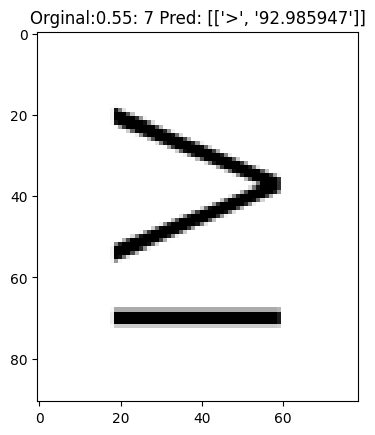

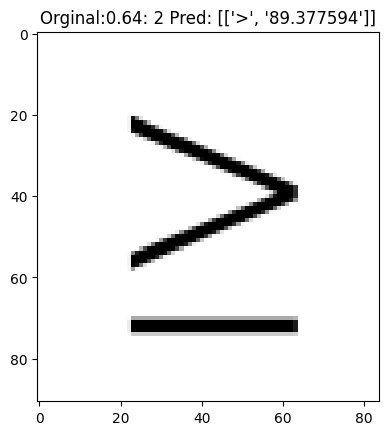

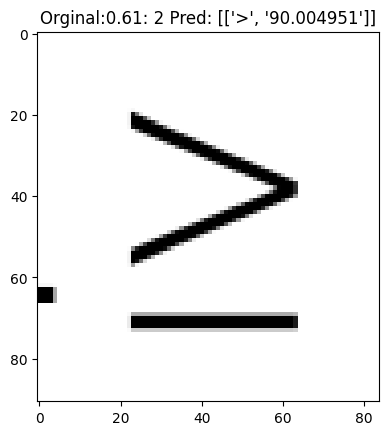

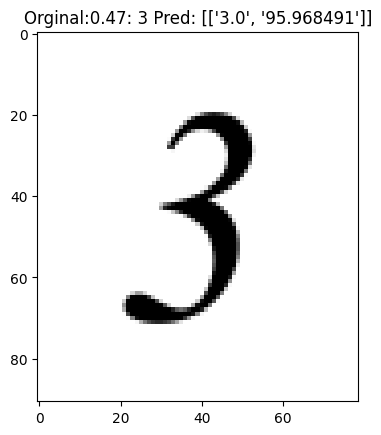

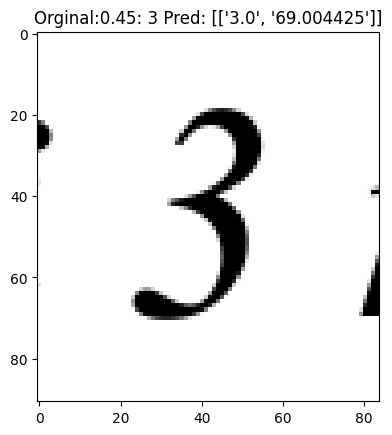

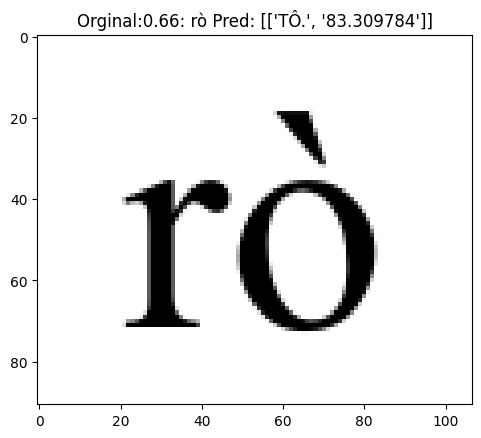

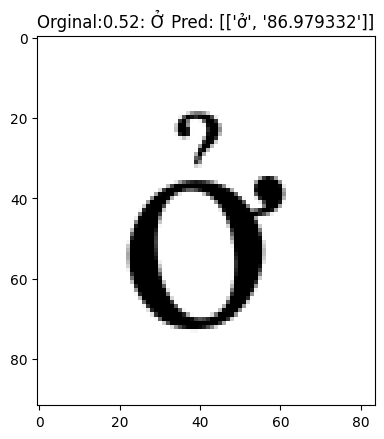

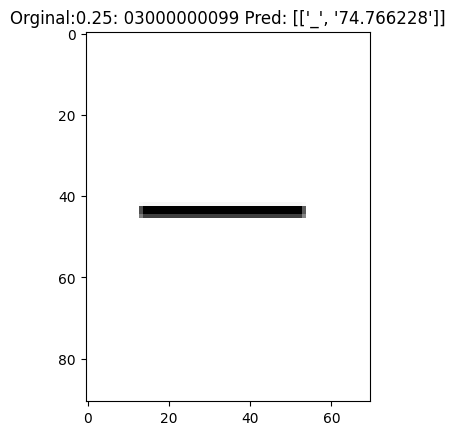

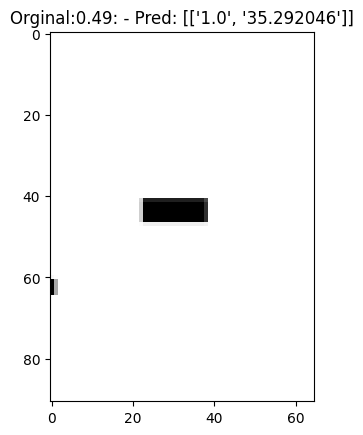

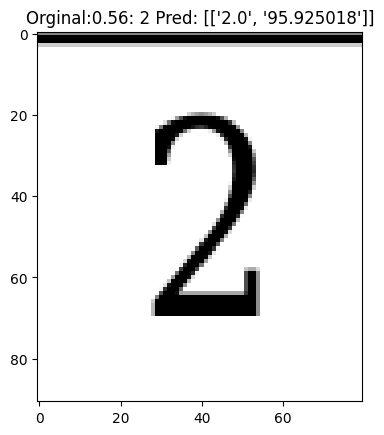

In [ ]:
tab = []
for pred, patch in zip(low_char, patches[1]):
    data = unstructured_pytesseract.image_to_data(patch, config=r'--psm 8 --oem 1 -l vie')
    table = pd.read_csv(StringIO(data), sep='\t').dropna()
    plt.title(f"Orginal:{pred} Pred: {table[['text', 'conf']].astype(str).values.tolist()}")
    plt.imshow(patch)
    plt.pause(0.5)
    tab.append(table)

In [ ]:
tab = pd.concat(tab)

In [ ]:
tab

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,19,19,41,53,92.985947,>
4,5,1,1,1,1,1,23,21,41,53,89.377594,>
4,5,1,1,1,1,1,0,20,64,53,90.004951,>
4,5,1,1,1,1,1,22,20,31,52,95.968491,3.0
4,5,1,1,1,1,1,0,19,84,52,69.004425,3.0
4,5,1,1,1,1,1,22,19,61,54,83.309784,TÔ.
4,5,1,1,1,1,1,23,19,38,54,86.979332,ở
4,5,1,1,1,1,1,13,43,41,3,74.766228,_
4,5,1,1,1,1,1,0,61,1,4,35.292046,1.0
4,5,1,1,1,1,1,0,1,80,69,95.925018,2.0
